In [138]:
from networkx.algorithms.tree.mst import SpanningTreeIterator
import matplotlib.pyplot as plt
import tree_utils as tu
from tqdm import tqdm
import networkx as nx
import numpy as np
import random
from tree_partition import sample_uniform_partition_of_tree

In [2]:
def generate_grid_graph(N):
    g = nx.grid_graph(dim=(N,N))
    # nx.relabel_nodes(g, {node: (N * node[0]) + node[1] + 1 for node in g.nodes}, copy=False)
    for edge in g.edges:
        u, v = edge
        g[u][v]['weight'] = 1
    return g

def enumerate_all_trees(g):
    trees = SpanningTreeIterator(g)
    trees = []
    for tree in tqdm(SpanningTreeIterator(g)):
        trees.append(tree)
    return trees

def sample_trees(g, func, N):
    trees = []
    for _ in tqdm(range(N)):
        tree = func(g)
        trees.append(tree)
    return trees

def make_tree_dict(trees, ds):
    tree_dict = {}
    for tree in tqdm(trees):
        d_dict = {}
        for d in ds:
            d_dict[d] = tu.find_balance_edge(tree, d)
        tree_dict[tree] = d_dict
    return tree_dict

def make_counting_dict(g, tree_dict, ds):
    counting_dict = {}
    for d in ds:
        counting_dict[d] = {e: 0 for e in g.edges}
        for tree in tree_dict:
            balance_edges = tree_dict[tree][d]
            for balance_edge in balance_edges:
                counting_dict[d][balance_edge] += 1
    return counting_dict

In [3]:
g = generate_grid_graph(6) 
# tu.draw(g)

In [11]:
num_trees = 100000
ust_trees = sample_trees(g, tu.uniform_random_spanning_tree, num_trees)
mst_trees = sample_trees(g, tu.random_minimum_spanning_tree, num_trees)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:54<00:00, 572.13it/s]


In [12]:
%%time
ds = [0]
ust_tree_dict = make_tree_dict(ust_trees, ds)
ust_counting_dict = make_counting_dict(g, ust_tree_dict, ds)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [16:21<00:00, 101.84it/s]


CPU times: user 16min 3s, sys: 17.7 s, total: 16min 20s
Wall time: 16min 22s


In [13]:
%%time
ds = [0]
mst_tree_dict = make_tree_dict(mst_trees, ds)
mst_counting_dict = make_counting_dict(g, mst_tree_dict, ds)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [16:21<00:00, 101.87it/s]


CPU times: user 16min 2s, sys: 17.3 s, total: 16min 19s
Wall time: 16min 21s


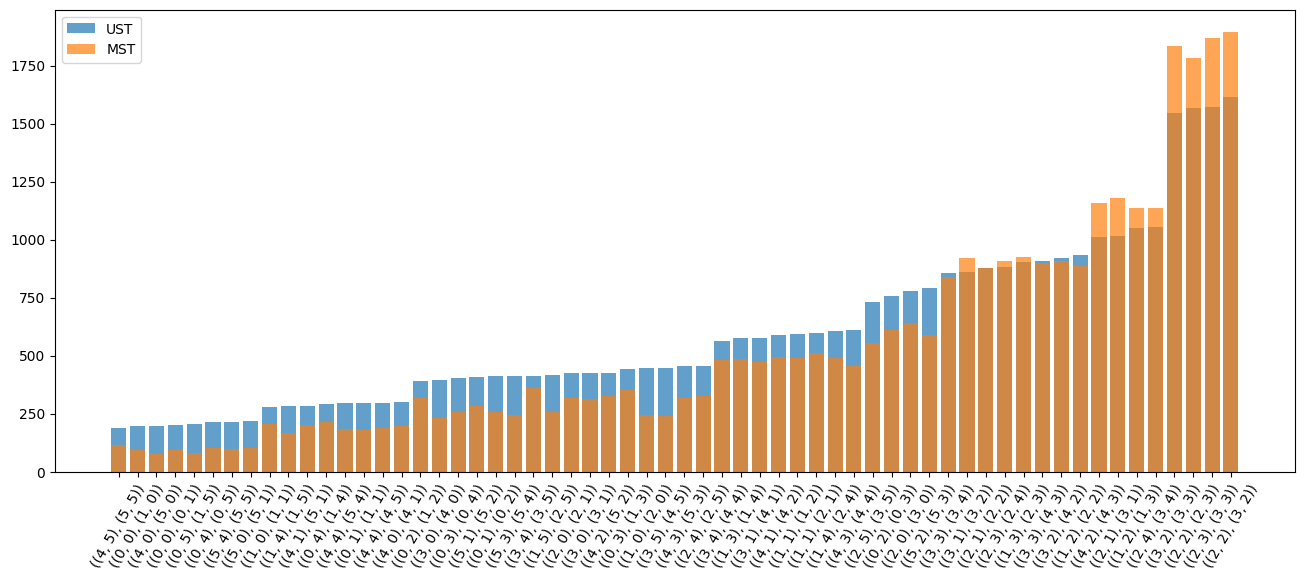

In [14]:
fig, ax = plt.subplots(figsize=(16,6))

for (d, label) in [(ust_counting_dict, "UST"), (mst_counting_dict, "MST")]:
    data = d[0]
    sorted_data = dict(sorted(data.items(), key=lambda item: item[1]))
    edges = [str(x) for x in sorted_data.keys()]
    frequencies = list(sorted_data.values())

    plt.bar(edges, frequencies, align='center', alpha=0.7, label=label)
    plt.xticks(rotation = 60)
plt.legend()
plt.show()

In [137]:
def sample_uniform_partition_of_tree(spanning_tree, num_parts, min_pop, max_pop, pop_col):
    # Initialize spanning tree and m, which stores partial partitions of nodes that have been removed.
    #print(spanning_tree.nodes[0][pop_col])
    spanning_tree = spanning_tree.copy()
    m = {node: {(spanning_tree.nodes[node][pop_col], 0, False): ([], [node], 1)} for node in spanning_tree}

    # Main loop, contracts leaves and updates m until there is only one node left.
    leaves = [node for node in spanning_tree if spanning_tree.degree(node) == 1]
    last_node = None
    while last_node is None:
        # Contract leaf from graph.
        leaf = leaves.pop()
        parent = get_parent(spanning_tree, leaf)
        spanning_tree.remove_node(leaf)
        deg = spanning_tree.degree(parent)
        if deg == 0:
            last_node = parent
        elif deg == 1:
            leaves.append(parent)

        # Compute all possible partitions of the parent subtree, labeled by residue and partition size.
        parent_partitions = {}
        def add_parent_partition(residue_size, partition_size, partition, residue, used, weight):
            if partition_size < num_parts or (partition_size == num_parts and residue_size == 0):
                residue_and_partition_size_and_used = (residue_size, partition_size, used)
                partition_and_residue_and_weight = (partition, residue, weight)
                if residue_and_partition_size_and_used in parent_partitions:
                    parent_partitions[residue_and_partition_size_and_used].append(partition_and_residue_and_weight)
                else:
                    parent_partitions[residue_and_partition_size_and_used] = [partition_and_residue_and_weight]
        for (p_residue_size, p_partition_size, p_used), (p_partition, p_residue, p_weight) in m[parent].items():
            for (l_residue_size, l_partition_size, l_used), (l_partition, l_residue, l_weight) in m[leaf].items():
                if p_used and not l_used:
                    continue
                residue_size = p_residue_size + l_residue_size
                if residue_size > max_pop:
                    continue
                partition_size = p_partition_size + l_partition_size
                partition = p_partition + l_partition
                residue = p_residue + l_residue
                weight = p_weight * l_weight
                add_parent_partition(residue_size, partition_size, partition, residue, False, weight)
                if residue_size >= min_pop and not l_used:
                    add_parent_partition(0, partition_size + 1, partition + [residue], [], True, weight)
​
        # Update m[parent] by sampling a random partition for each possible residue and partition size.
        m.pop(leaf)
        m[parent] = {}
        for residue_and_partition_size_and_used, partial_partitions in parent_partitions.items():
            partitions_and_residues = []
            weights = []
            total_weight = 0
            for partition, residue, weight in partial_partitions:
                partitions_and_residues.append((partition, residue))
                weights.append(weight)
                total_weight += weight
            m[parent][residue_and_partition_size_and_used] =\
                random.choices(partitions_and_residues, weights=weights, k=1)[0] + (total_weight,)
    assert spanning_tree.order() == 1 and last_node in spanning_tree
​
    # If a valid partition of the entire tree exists, it should contain zero population in its residue.
    #print(m)
    if (0, num_parts, True) in m[last_node]:
        final_partition, empty_residue, num_partitions = m[last_node][(0, num_parts, True)]
        return final_partition, num_partitions
    else:
        return None, 0

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 59)

In [127]:
%%time
slow_find_balance_edge(tree)

CPU times: user 84.1 ms, sys: 4.5 ms, total: 88.6 ms
Wall time: 87 ms


set()

In [148]:
%%time
tu.find_balance_edge(tree)

CPU times: user 91 ms, sys: 3.08 ms, total: 94.1 ms
Wall time: 95.9 ms


set()

In [175]:
tree = tu.random_minimum_spanning_tree(graph)
for n in tree:
    tree.nodes[n]['pop'] = 1
ideal_size = len(tree) / 2
sample_uniform_partition_of_tree(tree, 2, ideal_size, ideal_size, "pop")

([[(2, 1), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 2), (2, 3)],
  [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 1), (1, 0), (0, 3)]],
 1)

In [170]:
%%time


CPU times: user 281 µs, sys: 1 µs, total: 282 µs
Wall time: 287 µs


(None, 0)

(None, 0)

In [155]:
##
N = 4
graph = generate_grid_graph(N) 
d = 0
trials = 1000
snappables = 0
for _ in tqdm(range(trials)):
    # tree = tu.uniform_random_spanning_tree(graph)
    tree = tu.random_minimum_spanning_tree(graph)
    
    
    balance_edges = fast_find_balance_edge(tree)
    if balance_edges:
        snappables += 1
print(snappables/trials)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 876.68it/s]

0.513


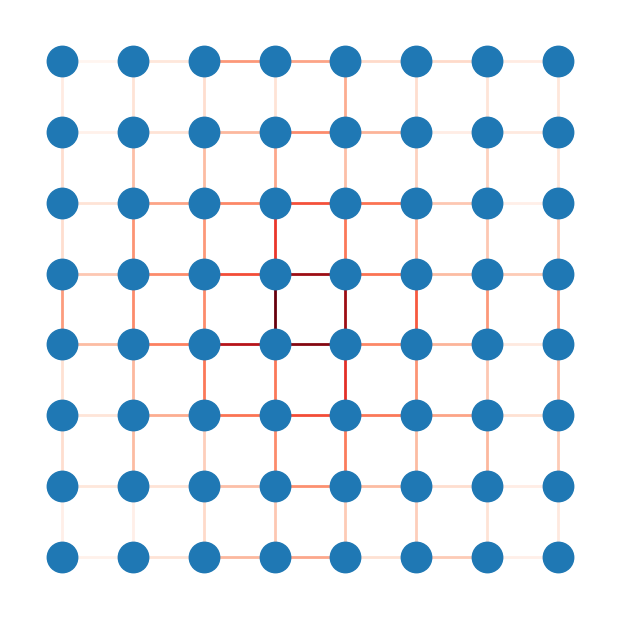

In [ ]:
N = 6
plt.figure(figsize=(N,N)) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(g, 
        pos={(x,y): (x, y) for x,y in g.nodes()},
        width=2,
        with_labels=False,
        node_size=80*N,
        edge_color=[ust_counting_dict[0][e] for e in g.edges()],
        edge_cmap=plt.cm.Reds
       )
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
# sm.set_array([])
# plt.colorbar(sm, fraction=0.046, pad=0.01)
# plt.show()
plt.savefig("plots/8x8_u100k.png", dpi=300, bbox_inches='tight')

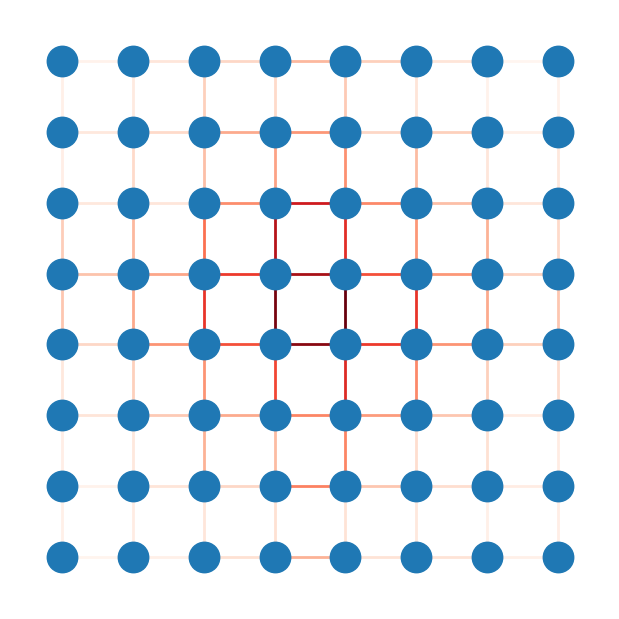

In [37]:
N = 6
plt.figure(figsize=(N,N)) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(g, 
        pos={(x,y): (x, y) for x,y in g.nodes()},
        width=2,
        with_labels=False,
        node_size=80*N,
        edge_color=[mst_counting_dict[0][e] for e in g.edges()],
        edge_cmap=plt.cm.Reds
       )
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
# sm.set_array([])
# plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.savefig("plots/8x8_m100k.png", dpi=300, bbox_inches='tight')
# plt.show()

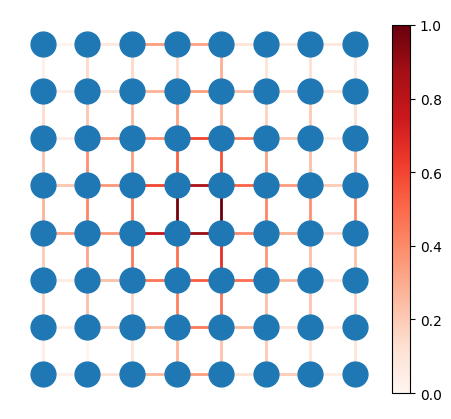

In [45]:
plt.figure(figsize=(N/2,N/2)) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(g, 
        pos={(x,y): (x, y) for x,y in g.nodes()},
        width=2,
        with_labels=False,
        node_size=80*N/2,
        edge_color=[counting_dict[0][e] for e in g.edges()],
        edge_cmap=plt.cm.Reds
       )
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

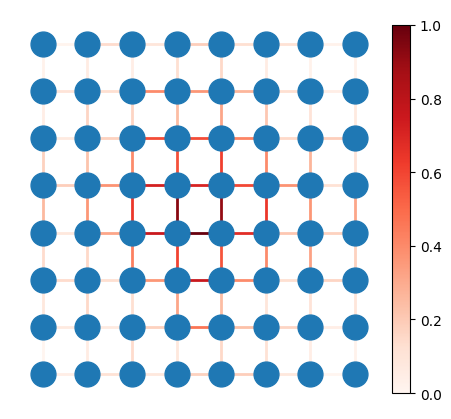

In [46]:
plt.figure(figsize=(N/2,N/2)) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(g, 
        pos={(x,y): (x, y) for x,y in g.nodes()},
        width=2,
        with_labels=False,
        node_size=80*N/2,
        edge_color=[mst_counting_dict[0][e] for e in g.edges()],
        edge_cmap=plt.cm.Reds
       )
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

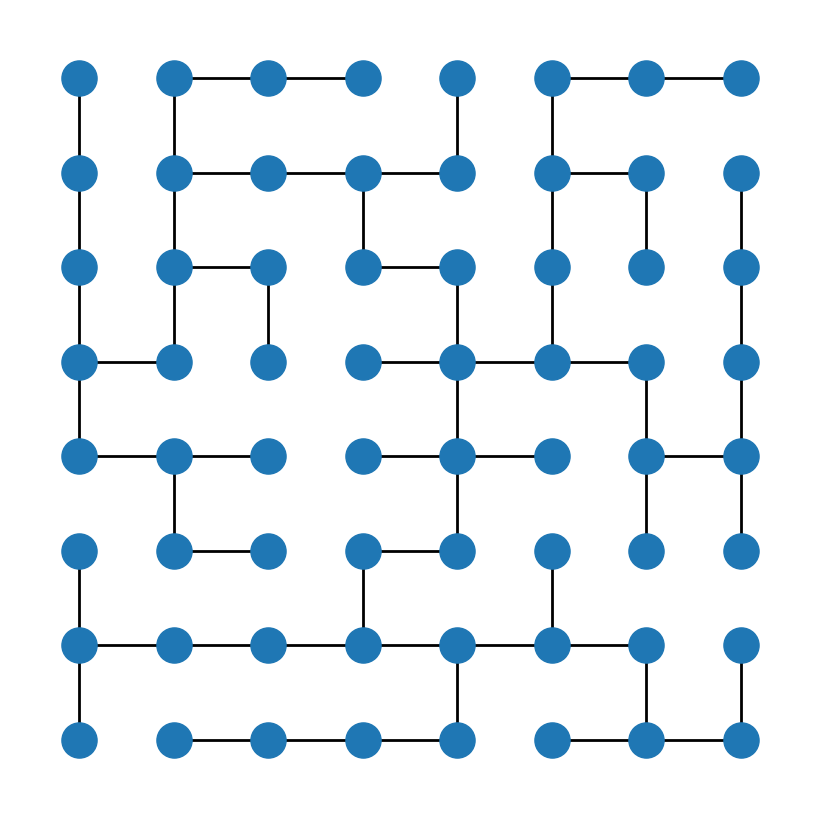

KeyboardInterrupt: 

In [41]:
d = 2
for tree in ust_tree_dict:
    for u, v, data in tree.edges(data=True):
        if (u,v) in ust_tree_dict[tree][d]:
            data['colors'] = 'red'
        else:
            data['colors'] = 'black'
    tu.draw(tree, edge_colors='c', delay=1)

In [93]:
sum(counting_dict[0].values())

53440

In [98]:
# two fractions could be interesting :
#    divide with number of spanning trees that have balance edges 
#    divide with number of spanning trees 

In [106]:
# this is normalized by the number of spanning trees
normalized_counting_dict = [counting_dict[0][e]/len(trees) for e in g.edges()] 
normalized_counting_dict

[0.008978396045918368,
 0.008978396045918368,
 0.014718191964285714,
 0.03515625,
 0.014718191964285714,
 0.008978396045918368,
 0.008978396045918368,
 0.03515625,
 0.014718191964285714,
 0.05058195153061224,
 0.05058195153061224,
 0.05058195153061224,
 0.014718191964285714,
 0.03515625,
 0.008978396045918368,
 0.014718191964285714,
 0.014718191964285714,
 0.05058195153061224,
 0.014718191964285714,
 0.014718191964285714,
 0.008978396045918368,
 0.008978396045918368,
 0.03515625,
 0.008978396045918368]